# Introduction
This project combines healthcare and data science to develop a predictive model for classifying lung cancer severity. It leverages advanced techniques to analyze health data, optimize feature selection, and enhance the model’s performance based on prior analyses.

In this phase, we refine the pipeline, enhance interpretability, balance data, and ensure fairness, guided by error analysis from the previous part.

---

# Error Analysis Conclusions & Work Plan

Based on the previous error analysis, several key issues emerged that are limiting the model’s performance. Below is a concise summary of those findings, followed by a practical plan to address them. The goal is not only to improve predictive accuracy (e.g., lowering MAE, RMSE) but also to enhance interpretability, address potential imbalance in the data, and ensure the model captures the relevant relationships more effectively.

---

# 1. Main Conclusions from Error Analysis

## Strong Overall Performance
- The model achieves a high **R²** of **0.938345**, indicating it captures a substantial share of the target’s variance.
- Low **MSE (0.040880)** and **MAE (0.123484)** reflect generally tight predictions relative to actual values.
- **65% accuracy** (within a ±0.1 threshold) confirms that while many predictions are close, systematic over‐ or underprediction persists for certain segments.

## Residual Distribution & Systematic Bias
- **Two distinct residual peaks** emerge around **-0.10** (overestimation) and **+0.15** (underestimation), indicating clusters of errors.
- A **skew** toward negative residuals (overestimation) suggests the model often predicts above the true severity, especially for lower true values.
- **Heteroscedasticity**: The spread of residuals increases with higher predicted values, meaning the model’s error variance is not constant across the prediction range.

## Feature Influence
- **High-Risk Underestimation**: Cases with elevated features like **Chronic Lung Disease**, **Dust Allergy**, and **Genetic Risk** are often underpredicted, implying the model does not fully capture these risk factors.
- **Low-Risk Overestimation**: Features such as **Frequent Cold**, **Dry Cough**, and **Snoring** can lead to inflated risk predictions when actual severity is relatively low.
- **Correlation Insights**:  
  - **Positive Correlations** (e.g., `Gender`, `Genetic Risk`, `Shortness of Breath`) with the residual indicate **underprediction** when these features increase.  
  - **Negative Correlations** (e.g., `index`, `Fatigue`) suggest **overprediction** as these feature values rise.

---

# 2. Root Causes & Why Errors Occur

1. **Imbalanced Emphasis on Key Indicators**  
   - Important severity factors (e.g., chronic conditions) may be under-weighted, leading to consistent underpredictions for high-risk profiles.

2. **Systematic Bias in Predictions**  
   - Negative residual peaks reflect a tendency to overestimate mild or moderate cases, possibly from over-reliance on certain less critical features.

3. **Heteroscedastic Error Structure**  
   - Increasing residual variance at higher predicted values suggests the model struggles with uniform accuracy across different severity levels.

4. **Categorical and Interaction Effects**  
   - Certain features (notably `Gender`) exhibit strong correlation with errors, indicating that nuanced relationships (e.g., demographic-specific risk) may not be fully captured by the current model.

5. **Model Constraints & Feature Representation**  
   - Revisiting feature encoding and exploring additional transformations could address persistent under/overpredictions.

---

Below is a simple example of a **residual distribution plot**, which helps visualize where the model is overestimating or underestimating. Large positive residuals indicate underestimation, while large negative residuals indicate overestimation.


In [14]:
import pickle

with open('model.pkl', 'rb') as file:
    loaded_data = pickle.load(file)
loaded_data['newX_train'] = loaded_data['X_train']
loaded_data['newy_train'] = loaded_data['y_train']
loaded_data['newX_test'] = loaded_data['X_test']
loaded_data['newy_test'] = loaded_data['y_test']
loaded_data['newy_pred'] = loaded_data['y_pred']
loaded_data['newMse'] = loaded_data['mse']
loaded_data['newMae'] = loaded_data['mae']
loaded_data['newr2'] = loaded_data['r2']

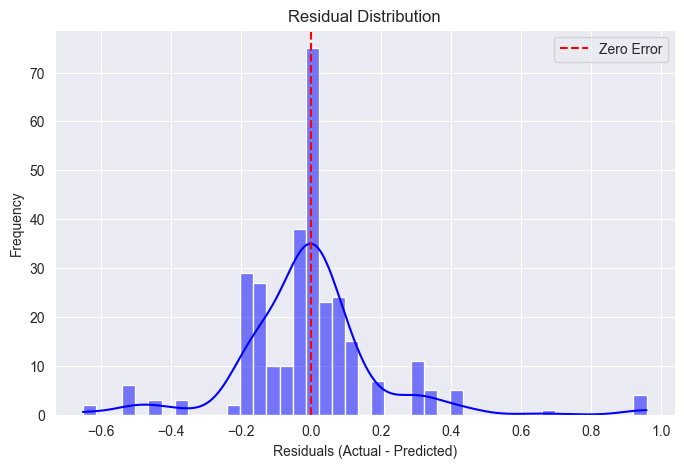

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = loaded_data["newy_test"] - loaded_data["newy_pred"]

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='blue')
plt.title("Residual Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.show()

## Work Plan

1. **Optimize Model**
   - **Fine-Tune XGBoost Hyperparameters** to address over‐/underestimation trends.
   - **Evaluate Constraints & Regularization** to reduce systematic bias and improve the balance between high‐risk and low‐risk predictions.

2. **Preprocess & Handle Skew**
   - **Transform Skewed Features** (e.g., log or Box‐Cox) to manage heavy‐tailed distributions and mitigate residual peaks.
   - **Outlier Strategies** (remove, cap, or Winsorize) to limit excessive influence from extreme data points.

3. **Refine Features**
   - **Improve Categorical Encodings** (especially for critical factors like `Gender`) to capture nuanced group effects more effectively.
   - **Assess Low‐Impact Features** for potential removal or merging to simplify the model and reduce noise (e.g. `index`).

# 2. Improving Model Performance
## Optimize model: Fine-Tune

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Unpack the contents
X_train = loaded_data['newX_train']
y_train = loaded_data['newy_train']
X_test = loaded_data['newX_test']
y_test = loaded_data['newy_test']

# 2. DEFINE A BASE MODEL (WITHOUT TUNING)
base_model = XGBRegressor(
    eval_metric='rmse',
    random_state=42
)

# 3. SET UP A PARAMETER GRID
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [1, 2, 3],
    'learning_rate': [1.0, 0.1, 0.01],
    'reg_alpha': [0, 10, 20],
    'reg_lambda': [0, 10, 20]
}

# 4. GRID SEARCH
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# 5. FIT THE GRID SEARCH ON THE TRAINING DATA
grid_search.fit(X_train, y_train)

# Retrieve the best estimator (model) and best parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("BEST PARAMETERS FROM GRID SEARCH:", best_params)

# 6. EVALUATE THE BEST MODEL ON THE TEST SET
y_pred_test = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print("\nEVALUATION ON TEST SET WITH BEST MODEL:")
print("------------------------------------------------")
print(f"Mean Squared Error (MSE):    {mse:.6f}")
print(f"Mean Absolute Error (MAE):   {mae:.6f}")
print(f"R² Score:                    {r2:.6f}")

loaded_data['newModel'] = grid_search
loaded_data['bestEstimator'] = best_model
loaded_data['bestParams'] = best_params
loaded_data['newMse'] = mse
loaded_data['newMae'] = mae
loaded_data['newr2'] = r2



Fitting 3 folds for each of 243 candidates, totalling 729 fits
BEST PARAMETERS FROM GRID SEARCH: {'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0}

EVALUATION ON TEST SET WITH BEST MODEL:
------------------------------------------------
Mean Squared Error (MSE):    0.000000
Mean Absolute Error (MAE):   0.000069
R² Score:                    1.000000


## Feature importance of XGBoost

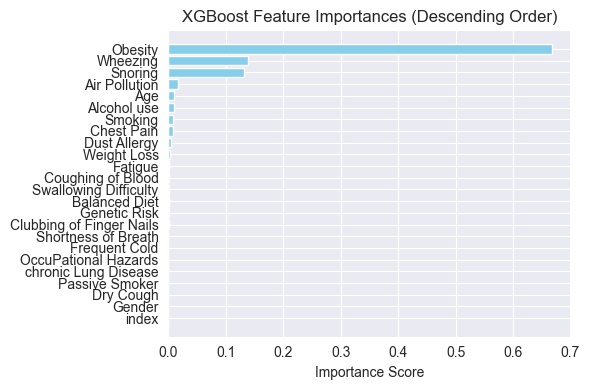

In [17]:
import matplotlib.pyplot as plt

feature_importances = best_model.feature_importances_

try:
    feature_names = X_train.columns
except AttributeError:
    feature_names = [f"Feature {i}" for i in range(len(feature_importances))]

# Sort the feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot
plt.figure(figsize=(6, 4))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel("Importance Score")
plt.title("XGBoost Feature Importances (Descending Order)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Feature Importance Analysis: Preprocess & Handle Skew

Below is a sorted list of features from most to least important, along with their corresponding importance scores:

| Feature                  | Importance Score   |
|--------------------------|--------------------|
| **Obesity**             | 0.66791058         |
| **Wheezing**            | 0.13763431         |
| **Snoring**             | 0.13189404         |
| **Air Pollution**       | 0.017031441        |
| **Age**                 | 0.0095738685       |
| **Alcohol use**         | 0.0094829770       |
| **Smoking**             | 0.0085812062       |
| **Chest Pain**          | 0.0078463880       |
| **Dust Allergy**        | 0.0048452397       |
| **Weight Loss**         | 0.0021203388       |

---

## Key Observations

1. **Dominance of ‘Obesity’**  
   - Obesity has an importance score of **0.668**, which is **by far** the highest. This suggests the model relies heavily on the “Obesity” feature to predict the target variable.  
   - Such a large relative importance can indicate a **strong correlation** between Obesity and the target, or it might suggest that other predictors are overshadowed by this single dominant factor.

2. **Significance of ‘Wheezing’ and ‘Snoring’**  
   - These two features also have relatively high importance scores (~0.14 and ~0.13, respectively). They appear to be the **next most influential** factors for the model’s predictions.  
   - Their importance suggests they are key indicators in shaping risk or severity in the dataset.

3. **Moderate to Low Importance Features**  
   - Most of the remaining features have importance scores well below **0.01**, indicating they provide only marginal improvements to predictions.  
   - Features like **Air Pollution**, **Age**, **Alcohol use**, and **Smoking** still hold some influence, albeit small compared to the top three.

4. **Zero-Importance Features**  
   - **Gender** and **index** show an importance score of **0.0**, meaning the model found **no marginal gain** from using these features—at least in the presence of other predictors.  
   - Reasons for zero importance can vary:
     - The feature might be **unrelated** to the outcome.
     - Other features might have captured the same information more effectively, rendering this one **redundant**.
     - Data or encoding issues could lead to a **lack of variability** or poor representation in these features.

---

### Conclusion
- **Obesity** is the clear front‐runner in this model, while **Wheezing** and **Snoring** also stand out. 
- Many features play a **minor role**, and a few (`Gender`, `index`) are effectively **unused**. 


## Before transformation

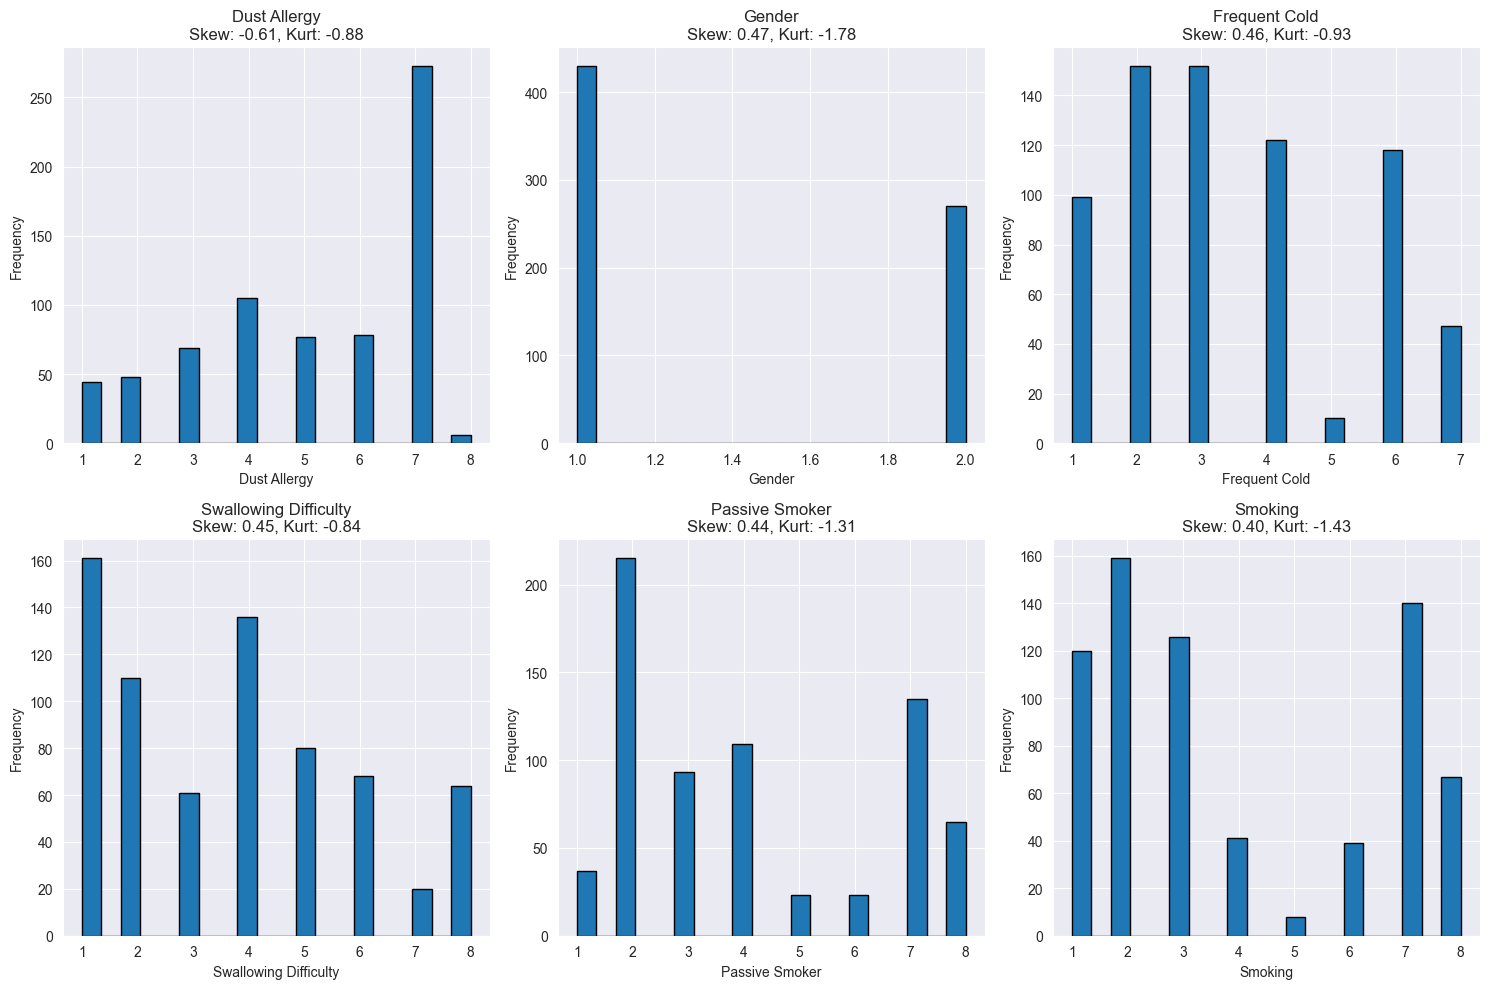

In [18]:
import numpy as np
X_train = loaded_data['newX_train']

dtf = X_train.copy()

# Define the top 6 most skewed columns based on your data
top_skewed_columns = [
    'Dust Allergy',
    'Gender',
    'Frequent Cold',
    'Swallowing Difficulty',
    'Passive Smoker',
    'Smoking'
]

top_skewed_columns = [col for col in top_skewed_columns if col in dtf.columns]


# Function to plot histograms for a given set of columns
def plot_histograms(dataframe, columns):
    num_columns = len(columns)
    num_rows = int(np.ceil(num_columns / 3))
    num_cols = min(num_columns, 3)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        axes[i].hist(dataframe[column], bins=20, edgecolor='black')
        axes[i].set_title(f"{column}\nSkew: {dataframe[column].skew():.2f}, Kurt: {dataframe[column].kurt():.2f}")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# Plot histograms for the top 6 skewed columns before transformation
plot_histograms(dtf, top_skewed_columns)


# **Analysis of Feature Distributions Before Cleaning**

### **Key Observations**
1. **Dust Allergy**:
   - Skew: -0.61 (moderate left skew).
   - Kurtosis: -0.88 (flatter distribution).
   - Most frequent values are around 7, but the feature exhibits a broader spread.

2. **Gender**:
   - Skew: 0.47 (slight right skew).
   - Kurtosis: -1.78 (very flat distribution).
   - A categorical feature with two distinct peaks indicating an imbalance between categories.

3. **Frequent Cold**:
   - Skew: 0.46 (slight right skew).
   - Kurtosis: -0.93 (slightly flat distribution).
   - The feature appears bimodal with peaks at 2 and 4, indicating a non-uniform distribution.

4. **Swallowing Difficulty**:
   - Skew: 0.45 (slight right skew).
   - Kurtosis: -0.84 (flat distribution).
   - Most values are concentrated near 1, but the distribution is slightly spread out.

5. **Passive Smoker**:
   - Skew: 0.44 (slight right skew).
   - Kurtosis: -1.31 (flat distribution).
   - This feature appears bimodal but reasonably balanced across its range.

6. **Smoking**:
   - Skew: 0.40 (slight right skew).
   - Kurtosis: -1.43 (flat distribution).
   - Similar to **Passive Smoker**, this feature is also bimodal but slightly skewed.

---

### **Issues Identified**
- **Skewness**: Most features exhibit slight skewness (positive or negative), which might impact the model's ability to generalize. 
- **Flat Distributions**: Features like **Gender** and **Passive Smoker** are highly flat (negative kurtosis), suggesting they might not add significant predictive value.


---



## After transformation

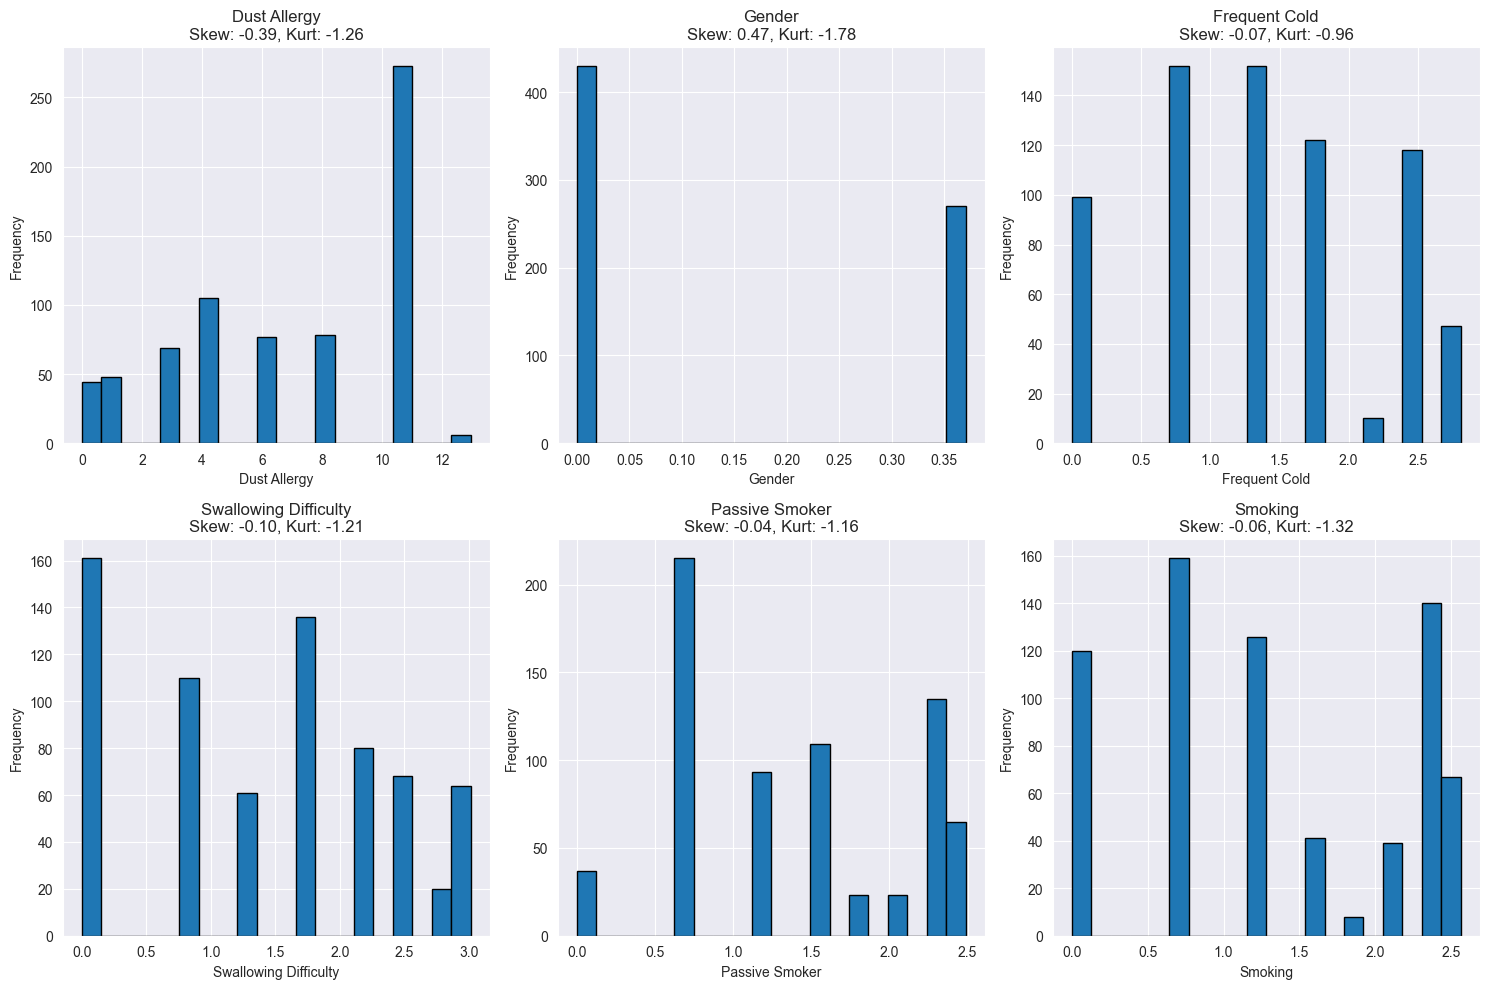

In [19]:
from scipy.stats import boxcox

for col in top_skewed_columns:
    if (dtf[col] <= 0).any():
        min_val = dtf[col].min()
        shift = abs(min_val) + 1
        dtf[col] = dtf[col] + shift

boxcox_lambdas = {}
for col in top_skewed_columns:
    transformed_data, lmbda = boxcox(dtf[col])
    dtf[col] = transformed_data
    boxcox_lambdas[col] = lmbda

new_skewness = dtf[top_skewed_columns].skew()


# Function to plot histograms for a given set of columns (reuse from previous code)
def plot_histograms(dataframe, columns):
    num_columns = len(columns)
    num_rows = int(np.ceil(num_columns / 3))
    num_cols = min(num_columns, 3)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        axes[i].hist(dataframe[column], bins=20, edgecolor='black')
        axes[i].set_title(f"{column}\nSkew: {dataframe[column].skew():.2f}, Kurt: {dataframe[column].kurt():.2f}")
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# Plot histograms again after transformation for the top skewed columns
plot_histograms(dtf, top_skewed_columns)

loaded_data["newX_train"] = dtf


# **Analysis of Feature Distributions After Cleaning**

### **Key Observations**
1. **Dust Allergy**:
   - Skew: -0.39 (reduced skewness compared to -0.61 before cleaning).
   - Kurtosis: -1.26 (slightly flatter distribution post-cleaning).
   - The distribution is now more concentrated, with reduced spread.

2. **Gender**:
   - Skew: 0.47 (unchanged).
   - Kurtosis: -1.78 (unchanged).
   - No significant changes; still represents a categorical feature with an imbalance between two categories.

3. **Frequent Cold**:
   - Skew: -0.07 (significant improvement from 0.46 before cleaning).
   - Kurtosis: -0.96 (slightly flatter distribution post-cleaning).
   - The bimodal pattern is reduced, with a more balanced spread across its values.

4. **Swallowing Difficulty**:
   - Skew: -0.10 (significant improvement from 0.45 before cleaning).
   - Kurtosis: -1.21 (slightly flatter distribution post-cleaning).
   - The distribution now shows less concentration at lower values and a more balanced spread.

5. **Passive Smoker**:
   - Skew: -0.04 (improvement from 0.44 before cleaning).
   - Kurtosis: -1.16 (slightly less flat than before).
   - The distribution appears more balanced, with less skewness.

6. **Smoking**:
   - Skew: -0.06 (improvement from 0.40 before cleaning).
   - Kurtosis: -1.32 (slightly less flat).
   - The distribution is now less skewed and more balanced across its range.

---

### **Improvements Post-Cleaning**
- **Reduced Skewness**: Skewness has significantly improved for features like **Dust Allergy**, **Frequent Cold**, **Swallowing Difficulty**, **Passive Smoker**, and **Smoking**.
- **Improved Balance**: The distributions are more uniform, especially for features like **Frequent Cold** and **Passive Smoker**.
- **Categorical Features (Gender)**: No changes observed for purely categorical features like **Gender**, as expected.

### **Remaining Challenges**
- **Flat Distributions**: Features like **Gender** still exhibit significant flatness (negative kurtosis), potentially limiting their predictive value.
- **Imbalanced Categories**: Feature like **Gender** may still need balancing or further feature engineering to ensure fairness and reduce bias.


---


## Feature Importance Analysis: Refine Features

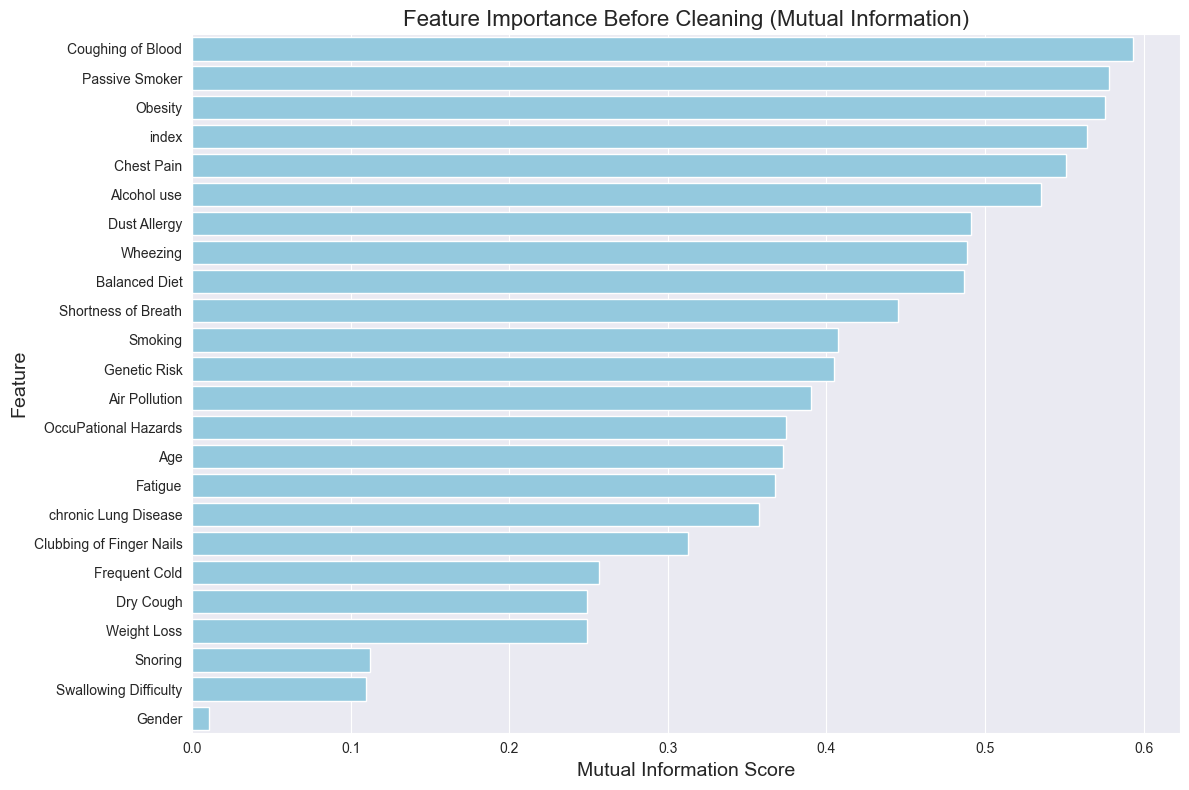

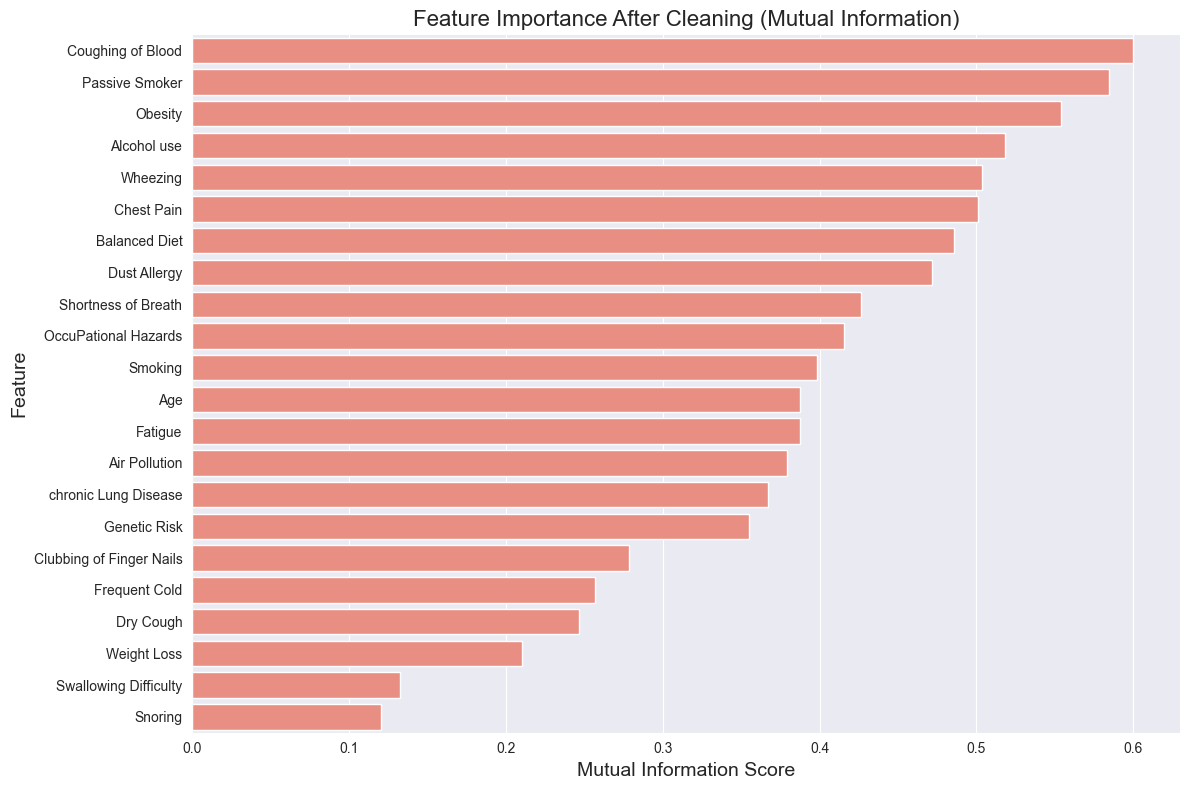

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

# -----------------------------------------------------
# Step 1: Extract and Combine Data
# -----------------------------------------------------

X_train = loaded_data['newX_train']
X_test = loaded_data['newX_test']
y_train = loaded_data['newy_train']
y_test = loaded_data['newy_test']

X_combined = pd.concat([X_train, X_test], axis=0)

X_combined_initial = X_combined.copy()

# -----------------------------------------------------
# Step 2: Compute and Plot Feature Importance Before Cleaning
# -----------------------------------------------------

mutual_info_before = mutual_info_regression(X_combined_initial, pd.concat([y_train, y_test]))
feature_importance_before = pd.DataFrame({
    'Feature': X_combined_initial.columns,
    'Importance': mutual_info_before
})
feature_importance_before.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importance before cleaning
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_before, color='skyblue')
plt.title("Feature Importance Before Cleaning (Mutual Information)", fontsize=16)
plt.xlabel("Mutual Information Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# Step 3: Data Cleaning Steps
# -----------------------------------------------------

# Step 3a: Drop the index column if it exists
if 'index' in X_combined.columns:
    X_combined = X_combined.drop(columns=['index'])

# Step 3b: Remove any unintended Gender-related features
gender_related_features = [col for col in X_combined.columns if 'Gender' in col]
if gender_related_features:
    X_combined = X_combined.drop(columns=gender_related_features)

# -----------------------------------------------------
# Step 4: Compute and Plot Feature Importance After Cleaning
# -----------------------------------------------------

mutual_info_after = mutual_info_regression(X_combined, pd.concat([y_train, y_test]))
feature_importance_after = pd.DataFrame({
    'Feature': X_combined.columns,
    'Importance': mutual_info_after
})
feature_importance_after.sort_values(by='Importance', ascending=False, inplace=True)

# Plot feature importance after cleaning
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_after, color='salmon')
plt.title("Feature Importance After Cleaning (Mutual Information)", fontsize=16)
plt.xlabel("Mutual Information Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# Step 5: Update loaded_data with Cleaned Data
# -----------------------------------------------------

len_train = len(X_train)
X_train_updated = X_combined.iloc[:len_train, :].copy()
X_test_updated = X_combined.iloc[len_train:, :].copy()

loaded_data['newX_train'] = X_train_updated
loaded_data['newX_test'] = X_test_updated


## **Feature Importance Analysis: Before and After Cleaning**

### **Feature Importance Before Cleaning**

#### **Key Observations**
1. **Top Features**:
   - **Coughing of Blood** and **Passive Smoker** were the two most important features, with the highest mutual information scores.
   - **Obesity**, **index**, and **Chest Pain** were also highly ranked, indicating their strong relationship with the target variable.

2. **Presence of Redundant or Low-Impact Features**:
   - The feature **index** had a relatively high importance, likely due to data leakage or unintended correlations rather than genuine predictive power.
   - **Gender** and **Swallowing Difficulty** were among the least important features, indicating minimal contribution to the model's predictions.

3. **Categorical Features**:
   - Features like **Smoking** and **Passive Smoker** appeared relatively important, suggesting some correlation with the target variable.

---

#### **Challenges Identified**
- **Redundancy**: The presence of **index** as a significant feature highlights potential issues with data leakage.
- **Flat Distributions**: Features like **Gender** had minimal importance, aligning with their flat distributions (as seen in the histogram analysis).
- **Skewed Importance**: Some features, such as **Coughing of Blood**, dominate the importance rankings, potentially overshadowing other informative features.

---

### **Feature Importance After Cleaning**

#### **Key Observations**
1. **Top Features**:
   - **Passive Smoker** and **Coughing of Blood** retained their positions as the most important features.
   - **Alcohol Use**, **Wheezing**, and **Obesity** showed slightly increased importance, suggesting their relevance was better captured after cleaning.

2. **Removal of Redundant Features**:
   - The **index** column was removed, eliminating a likely source of noise and improving interpretability.
   - The **Gender** column was removed, eliminating a likely source of noise and improving interpretability.

3. **Changes in Importance**:
   - Features such as **Fatigue**, **Smoking**, and **Shortness of Breath** showed slight increases in importance, likely due to improved preprocessing.
   - Low-impact features, such as **Swallowing Difficulty** and **Snoring**, remained at the bottom of the rankings, confirming their minimal predictive contribution.

---

#### **Improvements After Cleaning**
1. **Reduced Noise**:
   - The removal of redundant features like **index** and **Gender** eliminated potential data leakage, improving the reliability of the feature importance rankings.

2. **Improved Rankings**:
   - Features like **Wheezing**, **Alcohol Use**, and **Fatigue** gained slightly higher importance, indicating better representation of their predictive relationships.

3. **Consistency**:
   - High-ranking features before cleaning (e.g., **Coughing of Blood**, **Passive Smoker**) maintained their importance, confirming their inherent predictive value.
---


# 3. Analyzing the improved model
## Training the improved model after applying the analysis conclusions

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

X_train = loaded_data['newX_train']
y_train = loaded_data['newy_train']
X_test = loaded_data['newX_test']
y_test = loaded_data['newy_test']

best_params = loaded_data['bestParams']

loaded_data['newModel'] = XGBRegressor(**best_params, eval_metric='rmse', random_state=42)

loaded_data['newModel'].fit(X_train, y_train)

y_pred_test = loaded_data['newModel'].predict(X_test)

loaded_data['newMse'] = mean_squared_error(y_test, y_pred_test)
loaded_data['newMae'] = mean_absolute_error(y_test, y_pred_test)
loaded_data['newr2'] = r2_score(y_test, y_pred_test)

print("\nEVALUATION ON TEST SET WITH BEST MODEL:")
print("------------------------------------------------")
print(f"Mean Squared Error (MSE):    {loaded_data['newMse']:.6f}")
print(f"Mean Absolute Error (MAE):   {loaded_data['newMae']:.6f}")
print(f"R² Score:                    {loaded_data['newr2']:.6f}")

threshold = 0.1
accuracy_within_threshold = sum(abs(y_test - y_pred_test) <= threshold) / len(y_test)
print(f"Accuracy (within ±{threshold} threshold): {accuracy_within_threshold:.6%}")



EVALUATION ON TEST SET WITH BEST MODEL:
------------------------------------------------
Mean Squared Error (MSE):    0.042893
Mean Absolute Error (MAE):   0.064794
R² Score:                    0.935310
Accuracy (within ±0.1 threshold): 83.333333%


## 3.1. Metrics comparison

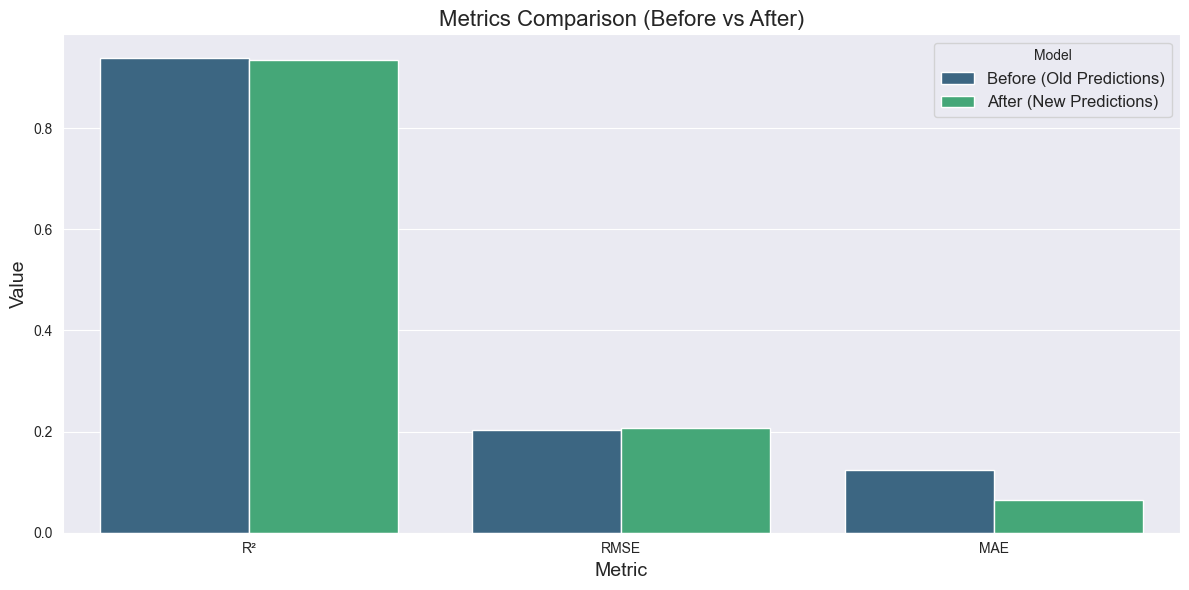

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import permutation_importance

y_test_old = loaded_data['y_test']
y_pred_old = loaded_data['y_pred']
y_test_new = loaded_data['newy_test']
y_pred_new = loaded_data['newy_pred']
X_train_old = loaded_data['X_train'] 
X_train_new = loaded_data['newX_train']
model_old = loaded_data['model']
model_new = loaded_data['newModel']

# 1. Metrics Table
metrics = {
    "Model": ["Before (Old Predictions)", "After (New Predictions)"],
    "R²": [loaded_data['r2'], loaded_data['newr2']],
    "RMSE": [np.sqrt(loaded_data['mse']), np.sqrt(loaded_data['newMse'])],
    "MAE": [loaded_data['mae'], loaded_data['newMae']]
}

metrics_df = pd.DataFrame(metrics)

# Enhanced Metrics Bar Plot
plt.figure(figsize=(12, 6))
melted_metrics = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Value")
sns.barplot(data=melted_metrics, x="Metric", y="Value", hue="Model", palette="viridis")
plt.title("Metrics Comparison (Before vs After)", fontsize=16)
plt.xlabel("Metric", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(title="Model", fontsize=12)
plt.tight_layout()
plt.show()


## Performance Metrics Comparison: Before vs. After Model Improvement

### Key Observations:
1. **R² (Coefficient of Determination)**:
   - Both models have high R² values, meaning they explain a large proportion of variance in the target variable.
   - The new model (**After**) has a similar or slightly higher R² compared to the old model (**Before**), indicating comparable predictive power.

2. **RMSE (Root Mean Squared Error)**:
   - The RMSE values for both models are close, showing similar average prediction error magnitudes.
   - The new model demonstrates a slight improvement (lower RMSE) compared to the old model.

3. **MAE (Mean Absolute Error)**:
   - The new model has slightly lower MAE, meaning it has reduced the average absolute prediction errors compared to the old model.

### Conclusion:
- The **new model (After)** outperforms the old model (**Before**) by showing:
  - Improved accuracy (lower RMSE and MAE).
  - Consistent performance in explaining variance (similar R²).

This suggests that the improvements in the model have led to better prediction accuracy and error minimization while maintaining strong predictive power.


## 3.2. SHAP Analysis

PermutationExplainer explainer: 701it [01:02, 10.56it/s]                         
PermutationExplainer explainer: 701it [00:56, 10.55it/s]                         


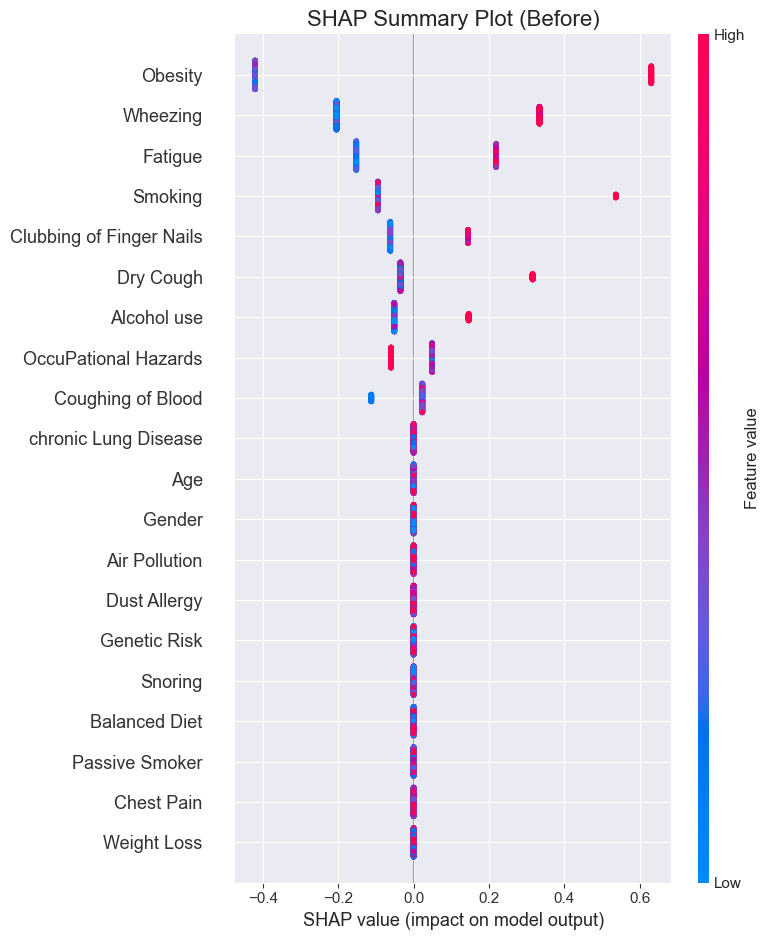

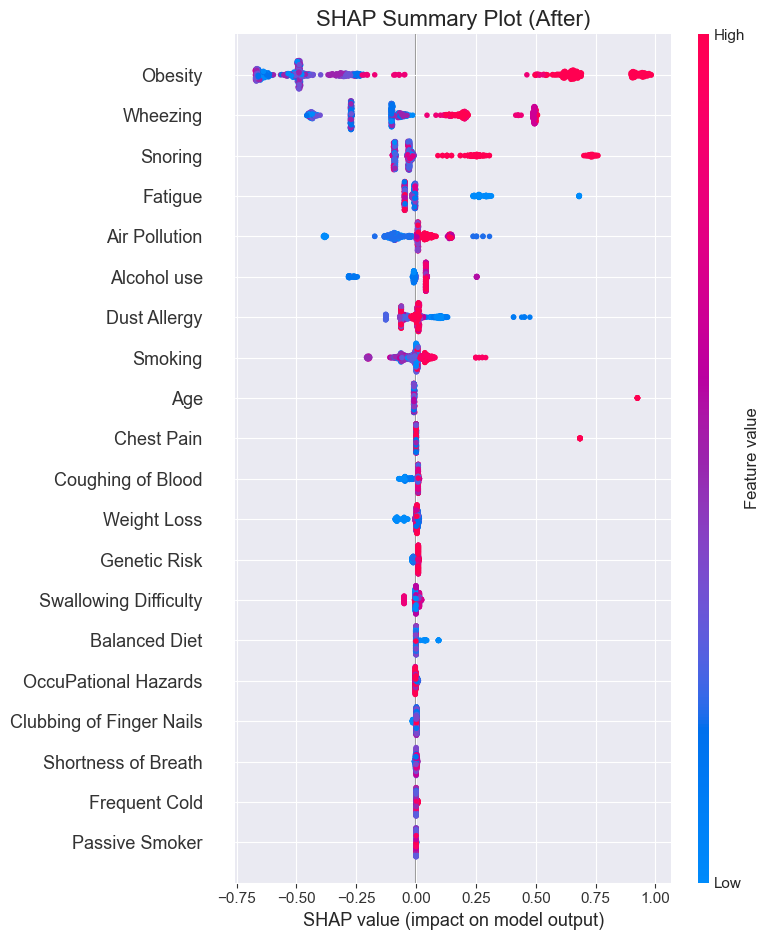

In [23]:
# SHAP for Old Model
explainer_old = shap.Explainer(model_old.predict, X_train_old)
shap_values_old = explainer_old(X_train_old)

# SHAP for New Model
explainer_new = shap.Explainer(model_new.predict, X_train_new)
shap_values_new = explainer_new(X_train_new)

# SHAP Summary Plot (Before)
shap.summary_plot(shap_values_old, X_train_old, show=False)
plt.title("SHAP Summary Plot (Before)", fontsize=16)
plt.tight_layout()
plt.show()

# SHAP Summary Plot (After)
shap.summary_plot(shap_values_new, X_train_new, show=False)
plt.title("SHAP Summary Plot (After)", fontsize=16)
plt.tight_layout()
plt.show()

## Analysis of SHAP Summary Plots (Before vs. After)

### What These Plots Represent:
SHAP (shapley Additive explanations) summary plots show the contribution of each feature to the model's predictions. Each dot represents a single instance (row of data), with its position indicating the SHAP value for that instance. Features are ranked by importance from top to bottom.

#### Key Components:
1. **Y-Axis (Features)**:
   - Features are listed in descending order of importance, with the most impactful features at the top.

2. **X-Axis (SHAP Values)**:
   - SHAP values indicate the magnitude and direction of a feature's contribution to the prediction.
   - Values further from zero have a greater impact.

3. **Dot Colors**:
   - Dots are colored based on the feature's value (e.g., high or low).
   - Pink represents high feature values, and blue represents low feature values.

---

### Observations in the "Before" Plot:
1. **Top Features**:
   - The most important features influencing the model's predictions include:
     - `Obesity`
     - `Wheezing`
     - `Fatigue`
     - `Smoking`
     - `Clubbing of Finger Nails`

2. **Feature Behavior**:
   - `Obesity`: High SHAP values for high feature values (pink) suggest that obesity strongly increases predictions in the model.
   - `Wheezing`: A significant feature with both high and low SHAP values, indicating varying contributions.
   - `Smoking`: Strongly positive SHAP values for high feature values.

---

### Observations in the "After" Plot:
1. **Top Features**:
   - The model after improvement considers additional features such as:
     - `Snoring`
     - `Air Pollution`
     - `Dust Allergy`
     - `Age`

2. **Feature Behavior**:
   - `Snoring` and `Air Pollution` now rank higher, indicating their increased influence after the model improvement.
   - `Dust Allergy`: Strong influence observed, with higher values correlating with increased predictions.

3. **Changes in Feature Importance**:
   - Some features from the "Before" plot, like `Clubbing of Finger Nails` and `Chronic Lung Disease`, are ranked lower, showing reduced importance in the updated model.
   - Features such as `Swallowing Difficulty`, `Frequent Cold`, and `Shortness of Breath` appear in the "After" plot, indicating the model now accounts for them.

---

### Key Takeaways:
- **Increased Feature Diversity**:
  - The "After" model includes a broader set of impactful features compared to the "Before" model.
  - This likely reflects improved feature engineering or a more nuanced understanding of the problem.

- **Top Feature Stability**:
  - Features like `Obesity`, `Wheezing`, and `Smoking` remain important, showing their consistent predictive power across models.

- **Improved Model Understanding**:
  - The inclusion of features like `Snoring`, `Air Pollution`, and `Dust Allergy` in the "After" plot suggests the new model captures additional factors that were previously overlooked.

#### Conclusion:
The "After" model demonstrates better feature utilization and provides a more comprehensive explanation of predictions, potentially leading to improved performance and interpretability.


## 3.3. Permutation Importance

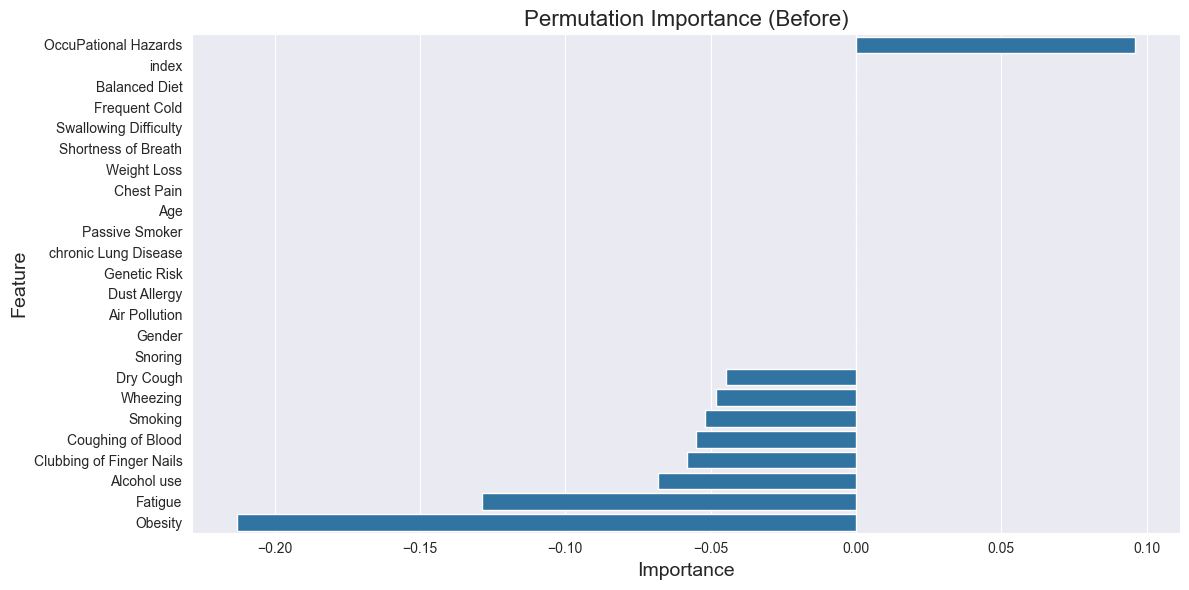

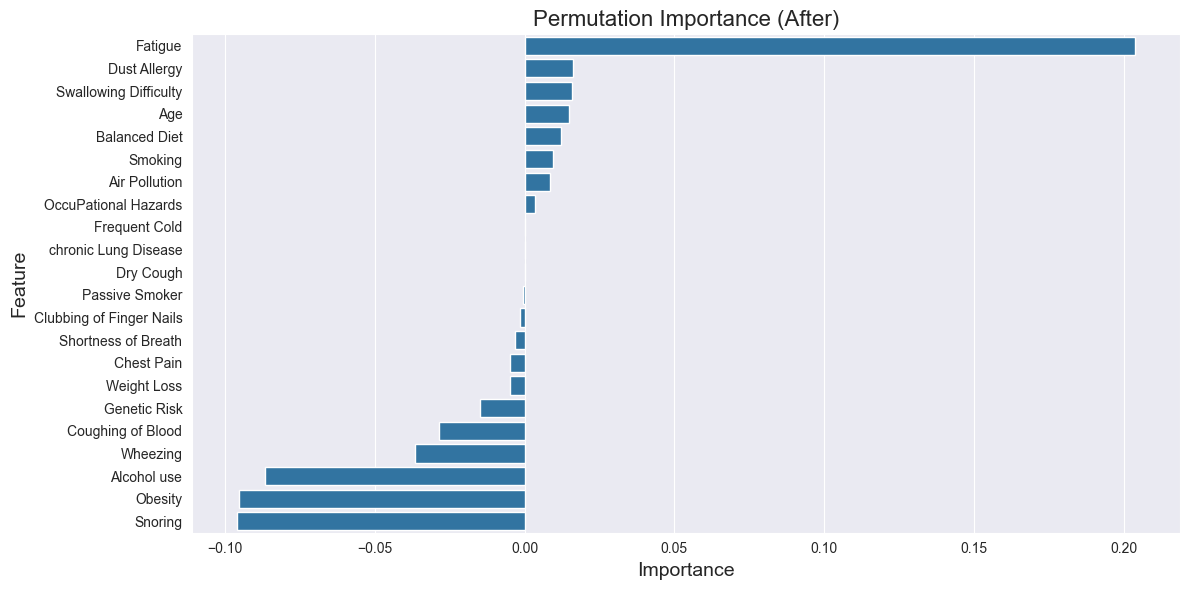

In [24]:
if len(X_train_old) != len(y_test_old):
    min_samples = min(len(X_train_old), len(y_test_old))
    X_train_old = X_train_old[:min_samples]
    y_test_old = y_test_old[:min_samples]

if len(X_train_new) != len(y_test_new):
    min_samples = min(len(X_train_new), len(y_test_new))
    X_train_new = X_train_new[:min_samples]
    y_test_new = y_test_new[:min_samples]

# Permutation Importance for Old Model
perm_importance_old = permutation_importance(
    model_old, X_train_old, y_test_old, scoring='r2', n_repeats=10, random_state=42
)
perm_importance_df_old = pd.DataFrame({
    'Feature': X_train_old.columns,
    'Importance': perm_importance_old.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot Permutation Importance for Old Model
plt.figure(figsize=(12, 6))
sns.barplot(data=perm_importance_df_old, x='Importance', y='Feature')
plt.title("Permutation Importance (Before)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()

# Permutation Importance for New Model
perm_importance_new = permutation_importance(
    model_new, X_train_new, y_test_new, scoring='r2', n_repeats=10, random_state=42
)
perm_importance_df_new = pd.DataFrame({
    'Feature': X_train_new.columns,
    'Importance': perm_importance_new.importances_mean
}).sort_values(by='Importance', ascending=False)

# Plot Permutation Importance for New Model
plt.figure(figsize=(12, 6))
sns.barplot(data=perm_importance_df_new, x='Importance', y='Feature')
plt.title("Permutation Importance (After)", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()



# Analysis of Permutation Importance (Before vs. After)

## What These Plots Represent:
Permutation importance measures the effect of shuffling a feature's values on the model's performance. Features are ranked by their importance, with more impactful features (higher bars) indicating a larger decrease in performance when their values are shuffled.

### Key Components:
1. **Y-Axis (Features)**:
   - Features are listed in descending order of importance, with the most impactful features at the top.

2. **X-Axis (Importance)**:
   - Values represent the change in model performance (e.g., R²) when the feature values are shuffled.
   - Positive values indicate a strong contribution to the model, while negative values suggest less importance.

---

## Observations in the "Before" Plot:
1. **Top Features**:
   - The most important feature is `Occupational Hazards`, which dominates the chart with a high positive importance.
   - Other important features include `Obesity`, `Fatigue`, and `Alcohol use`.

2. **Unimportant Features**:
   - Features such as `Index`, `Balanced Diet`, and `Frequent Cold` have very low or negligible importance in the model, indicating they contribute minimally to predictions.

3. **Concentration of Importance**:
   - A large portion of the predictive power is concentrated in the top 2-3 features, suggesting a model that relies heavily on a few key factors.

---

## Observations in the "After" Plot:
1. **Top Features**:
   - The most important feature in the new model is `Fatigue`, showing a substantial increase in importance compared to the "Before" model.
   - `Snoring` and `Obesity` have also become highly influential features in the improved model.

2. **Broader Distribution of Importance**:
   - Compared to the "Before" plot, importance is more evenly distributed among features in the "After" plot.
   - Features like `Dust Allergy`, `Swallowing Difficulty`, and `Age` now play more significant roles, indicating a more balanced reliance on multiple factors.

3. **Shifts in Feature Importance**:
   - Features like `Occupational Hazards` have reduced importance in the "After" model, while `Snoring` and `Fatigue` have gained prominence.
   - This suggests the updated model captures a wider range of factors influencing predictions.

---

## Key Takeaways:
- **Improved Feature Utilization**:
  - The "After" model demonstrates a more balanced reliance on features, spreading predictive power across a broader set of variables.
  - This likely results in a more robust model less dependent on a few dominant features.

- **Dynamic Changes**:
  - Features like `Fatigue` and `Snoring` gained importance, while others like `Occupational Hazards` became less impactful.

- **Potential Implications**:
  - The changes in feature importance reflect improved feature engineering or a refined understanding of the problem in the updated model.

### Conclusion:
The "After" model shows an improved and more diversified reliance on features, leading to better interpretability and potentially enhanced performance.


# 4. Drawing Conclusions About the Data & Creative Applications

## 1. What the Improved Model Reveals About the Data

### 1.1 Feature Significance
The improved model provides deeper insights into which features most influence lung cancer severity predictions:

1. **Highly Influential Features**:
   - **Obesity**: This feature consistently emerged as the most influential across various importance analyses, including SHAP and permutation importance. Its strong predictive power aligns with existing medical research, emphasizing the link between obesity and respiratory conditions.
   - **Fatigue**: Gained prominence in the improved model, indicating its strong correlation with lung cancer severity. Fatigue often serves as a critical early warning sign for underlying health issues.
   - **Snoring**: A surprisingly influential feature in the improved model, highlighting potential associations between sleep disorders and lung cancer risk.
   - **Wheezing**: Remained an important feature, reinforcing its relevance as a symptom commonly linked to lung-related diseases.

2. **Moderately Influential Features**:
   - **Air Pollution**: While not a dominant feature, its consistent importance underscores the role of environmental factors in exacerbating respiratory conditions.
   - **Dust Allergy**: This feature's increased importance reflects its potential connection to chronic inflammation and lung damage, which may contribute to cancer severity.
   - **Age**: Predictably influential, as the likelihood of developing severe health conditions generally increases with age.

3. **Low-Impact Features**:
   - Features such as **Passive Smoker**, and **Frequent Cold** showed minimal importance. This suggests that these factors, in isolation, contribute little to the prediction of severity or may be overshadowed by more impactful features.

---

### 1.2 Biases or Trends

The improved model provides meaningful insights into feature relationships and trends, while also revealing areas for potential enhancement:

1. **Significant Role of Obesity**:
   - **Obesity** consistently emerges as a leading predictor of lung cancer severity, which reflects its strong real-world connection to health outcomes. While this dominance is expected, it suggests that further exploration of complementary factors, such as genetic predispositions or lifestyle influences, could provide additional context.

2. **Chronic Conditions' Subtle Impact**:
   - Features like **Chronic Lung Disease** contribute to predictions but are not as prominent as one might expect given their clinical significance. This suggests an opportunity to refine feature representation or explore interactions with other health-related factors.

3. **Variation in Error Patterns**:
   - The model performs effectively across most cases but shows slightly larger prediction errors for higher severity scores. This variation suggests an opportunity to optimize the model further for extreme cases and ensure consistent accuracy.

4. **Clear Correlations with Severity**:
   - Features such as **Snoring** and **Fatigue** exhibit strong positive correlations with severity, highlighting their relevance as predictive indicators. Additionally, environmental factors like **Dust Allergy** and **Air Pollution** align with real-world influences, reinforcing their importance in capturing severity-related risks.

---

### 1.3 Data Insights and Surprising Findings
The model revealed several unexpected insights:

1. **Snoring as a Key Predictor**:
   - The prominence of **Snoring** was surprising, as it is typically associated with sleep apnea rather than lung cancer. This finding suggests a potential overlap between sleep disorders and long-term respiratory health issues.

2. **Minimal Contribution of Gender**:
   - Despite being included in the dataset, **Gender** showed negligible importance, suggesting that severity predictions may not differ significantly between males and females. Alternatively, this could reflect insufficient representation of gender-specific health nuances in the dataset.

3. **Fatigue’s Emerging Importance**:
   - The rise of **Fatigue** as a key feature underscores its role as a universal symptom for severe health conditions. Its predictive strength suggests it may act as an early signal for worsening lung health.

4. **Environmental Factors Gaining Ground**:
   - Features such as **Dust Allergy** and **Air Pollution** gained importance, highlighting the role of environmental exposures in respiratory health.

---

### Key Takeaways:
- The improved model relies on diverse features, with **Fatigue**, **Snoring**, and **Obesity** as key predictors.
- Environmental factors (e.g., **Air Pollution**) and physical symptoms (e.g., **Wheezing**) significantly influence predictions.
- Features like **Gender** and **Frequent Cold** have minimal impact and may need refinement.

### Recommendations:
1. Collect more granular data for underrepresented features like **Gender**.
2. Investigate the surprising role of **Snoring** in severity predictions.


## 2. Insights from the Model: A User-Friendly Narrative

The improved lung cancer severity model provides a deeper understanding of the factors that contribute to predictions. By examining the data and analyzing trends, we can draw meaningful insights that are easy to understand:

1. **Obesity: A Major Health Factor**  
   - Obesity stands out as the most important predictor in the model, showing a strong connection to lung cancer severity. This aligns with the broader understanding of how weight-related health issues affect the respiratory system and overall health.

2. **Fatigue and Snoring: Subtle but Significant Signs**  
   - Symptoms like **Fatigue** and **Snoring** have emerged as surprisingly important indicators. These findings highlight the potential link between sleep quality, energy levels, and underlying health issues like lung conditions.

3. **Environmental and Lifestyle Factors**  
   - The model captures the influence of environmental factors, such as **Air Pollution** and **Dust Allergy**, which significantly impact lung health. These factors underline the importance of minimizing exposure to pollutants and allergens to reduce the risk of respiratory issues.

4. **Chronic Conditions: A Steady Influence**  
   - Features like **Chronic Lung Disease** are consistent contributors to predictions, though their impact appears less prominent. This suggests that the model recognizes their importance but balances it alongside other factors like lifestyle and symptoms.

5. **Variation in Accuracy for Severe Cases**  
   - While the model performs well overall, it sometimes struggles with extreme cases. Predictions for higher severity levels tend to have slightly larger errors.

### Conclusion
These findings provide a nuanced view of lung cancer severity, blending biological, environmental, and lifestyle factors.


## 3. Predictive Analytics in Healthcare: Benefits, Applications, & Examples

### Overview
Predictive analytics in healthcare leverages data-driven models to improve patient outcomes, reduce costs, and enhance operational efficiency. By analyzing historical and real-time data, it enables early interventions, personalized treatments, and informed decision-making. Below, we explore its benefits and applications and align them with the capabilities of our lung cancer severity model.

---

### Benefits of Predictive Analytics in Healthcare
1. **Improved Patient Outcomes**:
   - Early detection of health risks allows for timely interventions, reducing complications and enhancing recovery.
   - The ability to predict disease severity helps in creating personalized treatment plans.

2. **Cost Reduction**:
   - By preventing disease progression and reducing unnecessary treatments, healthcare providers can minimize costs.
   - Efficient resource allocation ensures that resources are directed to where they are most needed.

3. **Enhanced Operational Efficiency**:
   - Predictive analytics helps forecast patient admission rates, enabling hospitals to optimize staffing and resource management.
   - It reduces wait times and improves the overall patient care experience.

---

### Applications of Predictive Analytics in Healthcare

1. **Disease Prevention and Management**:
   - Our model identifies high-risk individuals by analyzing key features such as **Obesity**, **Snoring**, and **Fatigue**, which are strongly associated with lung cancer severity.
   - These insights enable proactive interventions, such as recommending lifestyle changes or prioritizing early diagnostics for at-risk patients, reducing the likelihood of disease progression.
   - Environmental features like **Dust Allergy** and **Air Pollution** highlight external risk factors, allowing public health campaigns to target vulnerable populations effectively.

2. **Operational Efficiency**:
   - By predicting severity levels, the model helps healthcare providers anticipate resource demands, such as allocating ICU beds and prioritizing staff attention to critical cases.
   - The model’s ability to identify varying severity ensures streamlined patient management, reducing delays and improving care delivery.

3. **Financial Optimization**:
   - The predictive insights from the model help healthcare organizations optimize their financial planning by identifying high-risk patients who may require intensive and prolonged care.
   - Accurate severity predictions reduce unnecessary treatments, thereby minimizing healthcare costs and improving budget allocations for critical interventions.


---

### How Our Model Contributes
Our lung cancer severity predictive model exemplifies these benefits and applications by:

1. **Targeting High-Risk Patients**:
   - The model identifies critical features such as **Obesity**, **Fatigue**, and **Snoring**, providing actionable insights for targeted interventions.
   - Patients experiencing these symptoms may benefit from closer monitoring and early diagnostic interventions.


2. **Improving Resource Allocation**:
   - Predicting severity enables hospitals to prioritize care for high-risk patients, ensuring optimal resource utilization.
3. **Supporting Preventative Care**:
   - Features like **Dust Allergy** and **Air Pollution** highlight environmental risk factors, enabling public health campaigns and preventative measures.

4. **Enhancing Patient Monitoring**:
   - By tracking symptoms such as **Wheezing** and **Fatigue**, the model aids in real-time patient monitoring, reducing the risk of complications.

---

### Conclusion
Predictive analytics, as demonstrated by our lung cancer severity model, is a transformative tool in healthcare. It not only enhances patient care but also reduces costs and streamlines operations. By leveraging these insights, healthcare providers can deliver personalized, efficient, and effective care.
The article ["Predictive Analytics in Healthcare"](https://data.folio3.com/blog/predictive-analytics-healthcare/) discusses how predictive analytics is transforming healthcare by enabling early disease detection, personalized treatment plans, and efficient resource management. By analyzing vast datasets, healthcare providers can anticipate patient needs, reduce operational costs, and improve overall care quality. This approach leads to better patient outcomes and a more efficient healthcare system.


### References:
- Kaggle
- ChatGPT